In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
DATASET_FILEPATH = Path("../data/WIG-BANKI.csv")

We will omit NaN values, because we want to investigate the possibility of optimization instead of full analysis.

In [3]:
df = pd.read_csv(DATASET_FILEPATH, parse_dates=["Date"], index_col="Date")
df.head()

,BNP,ALR,BOS,MBK,MIL,SAN,ING,SPL,UCG,BHW,GTN,PEO,GNB,PKO
Date,,,,,,,,,,,,,,
2012-12-17,-0.012931,0.005759,-0.020408,0.000000,-0.002260,-0.008150,0.000000,-0.002021,-0.024782,-0.000992,0.003661,0.001749,-0.011299,0.009509
2012-12-18,-0.017467,0.016317,-0.010764,0.000000,0.004553,0.018476,-0.001110,0.004151,0.043974,0.002003,0.007296,0.000679,0.011429,-0.008552
2012-12-19,-0.011556,0.003211,0.026676,0.009695,-0.002278,0.007657,0.001111,0.000000,0.020445,0.001008,0.036405,0.007462,0.039548,0.017532
2012-12-20,-0.008993,-0.003201,-0.012308,-0.009893,0.009109,0.000051,0.005551,-0.002924,0.009697,-0.010000,-0.003586,0.027318,0.000000,0.014804
2012-12-21,-0.016334,0.000000,0.034960,0.000000,-0.006764,0.018104,0.002208,0.015017,0.000000,-0.015168,-0.014027,-0.001685,-0.010870,-0.016162


## Plot of daily returns

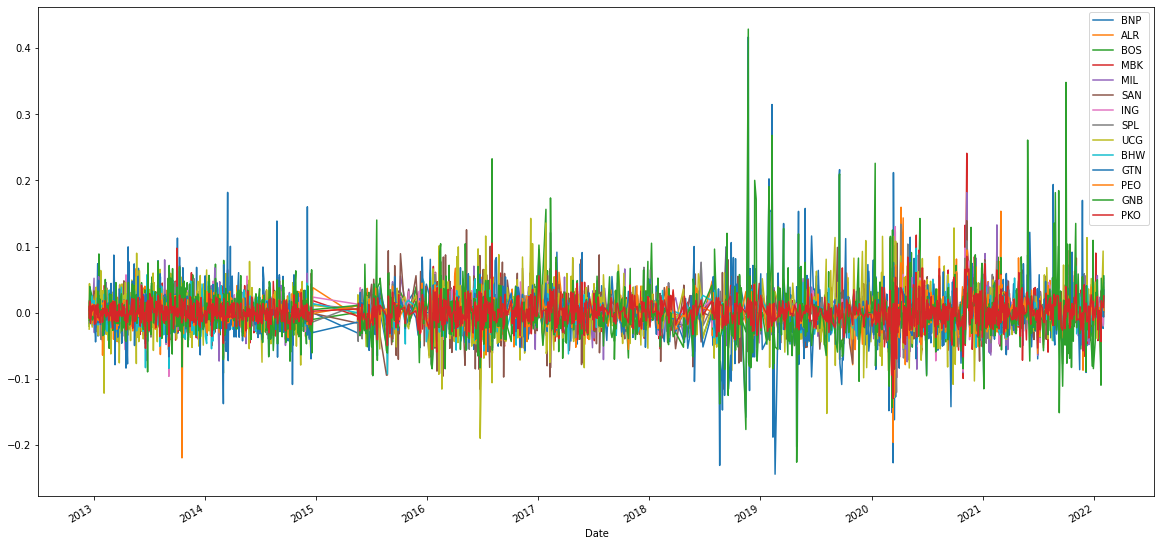

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(ax=ax)
plt.show()

## Mean and standard deviation of daily returns

In [5]:
mean_var_df = df.agg(["mean", "var"]).transpose()

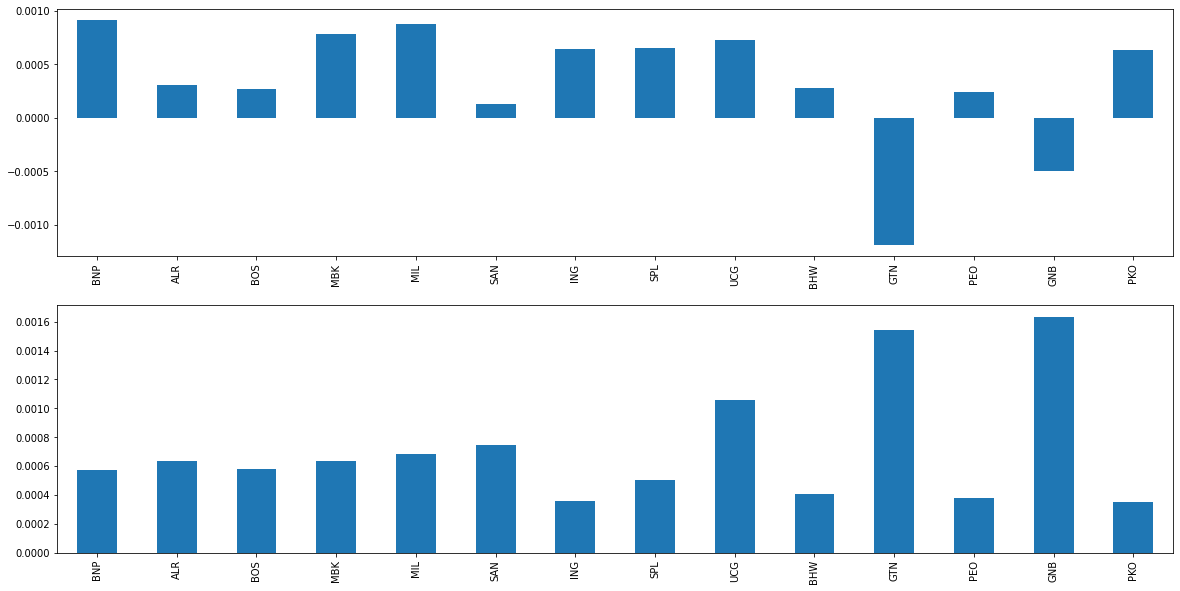

In [6]:
fig, axs = plt.subplots(2, figsize=(20, 10))
mean_var_df["mean"].plot(kind="bar", ax=axs[0])
mean_var_df["var"].plot(kind="bar", ax=axs[1])
plt.show()

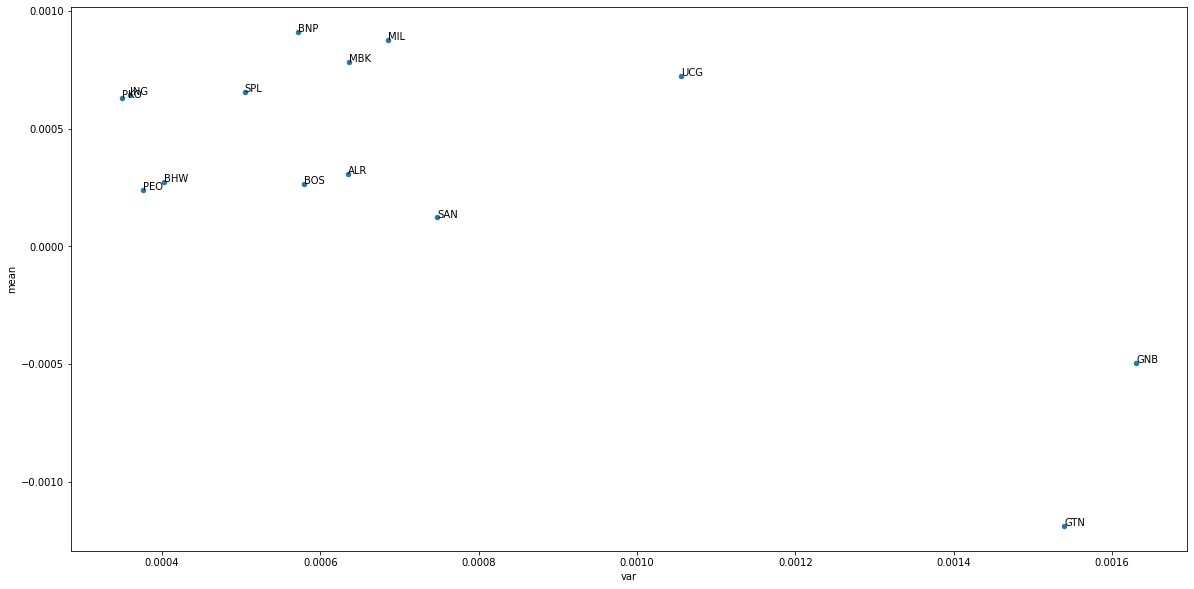

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_var_df.plot("var", "mean", kind="scatter", ax=ax)

for _, row in mean_var_df.iterrows():
    ax.annotate(row.name, (row["var"], row["mean"]))

plt.show()

## Correlation matrix of daily returns

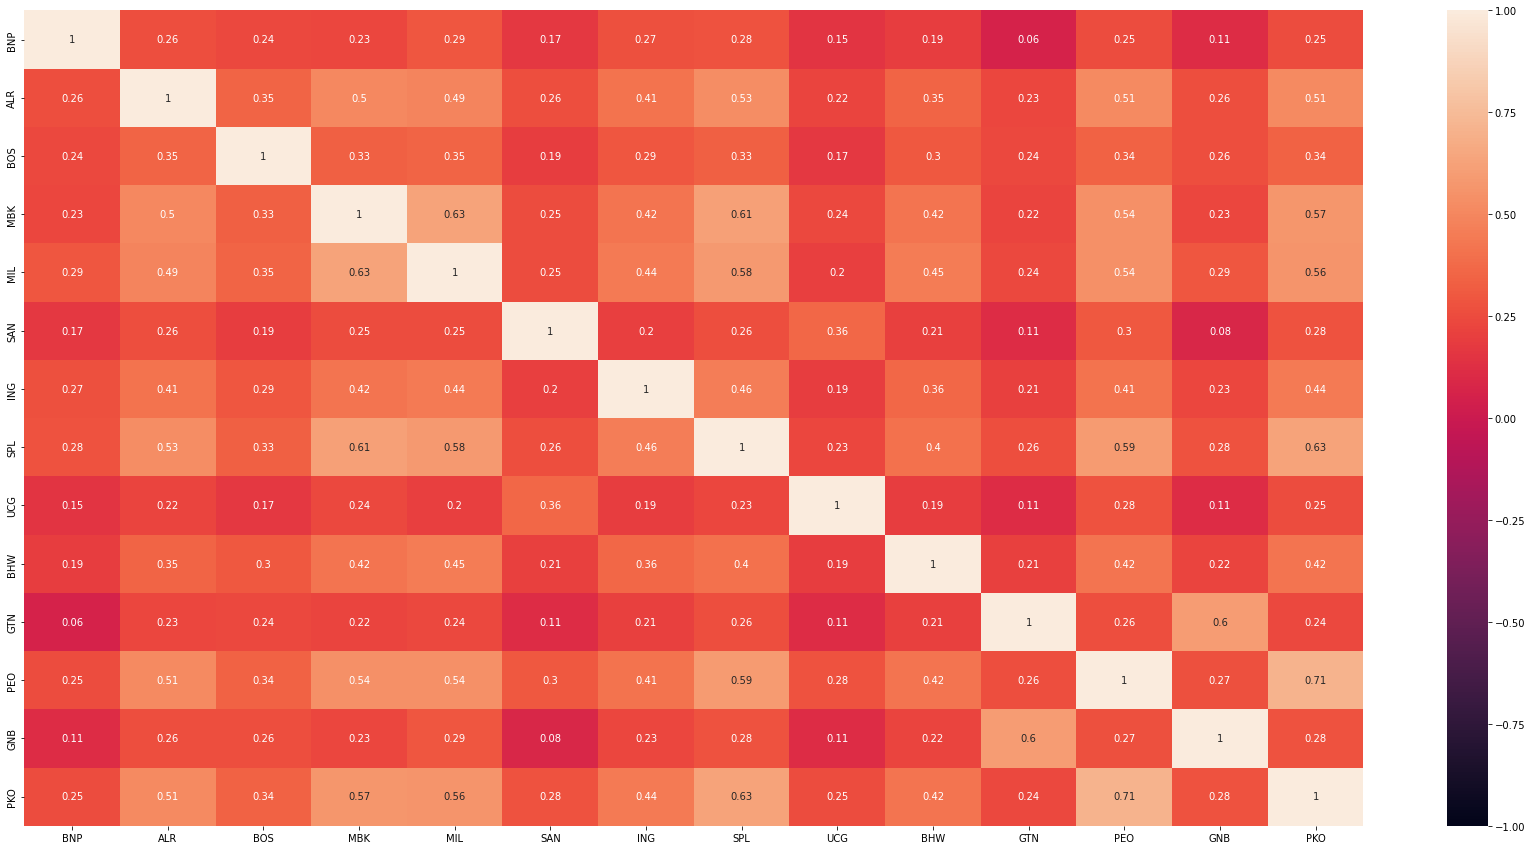

In [8]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(df.corr().round(2), ax=ax, annot=True, vmin=-1, vmax=1)
plt.show()

## Modern portfolio theory

In [9]:
from qpsolvers import solve_qp

In [10]:
SIGMA = df.cov().to_numpy()
R = df.mean().to_numpy()

In [11]:
def get_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1))

def get_nonnegative_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1), np.zeros_like(R))

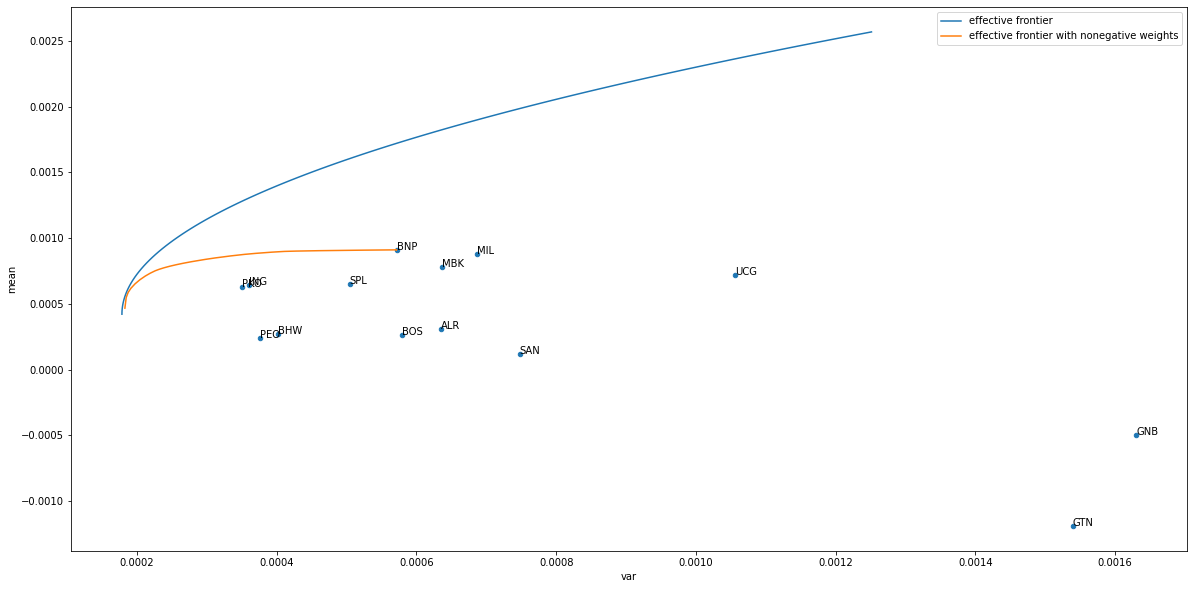

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_var_df.plot("var", "mean", kind="scatter", ax=ax)

for _, row in mean_var_df.iterrows():
    ax.annotate(row.name, (row["var"], row["mean"]))

arr = []
for q in np.linspace(0, 1, 100):
    w = get_weights(q)
    vol, ret = w.T @ SIGMA @ w, np.dot(R, w)
    arr.append([vol, ret])

nonneg_arr = []
for q in np.linspace(0, 50, 1000):
    w = get_nonnegative_weights(q)
    vol, ret = w.T @ SIGMA @ w, np.dot(R, w)
    nonneg_arr.append([vol, ret])

arr = np.array(arr)
nonneg_arr = np.array(nonneg_arr)
ax.plot(arr[:, 0], arr[:, 1], label="effective frontier")
ax.plot(nonneg_arr[:, 0], nonneg_arr[:, 1], label="effective frontier with nonegative weights")
ax.legend()
plt.show()

# Experiments with NSGA2

In [13]:
from nsga2.objectives import get_objective, portfolios_neg_returns, portfolios_vars, portfolios_empirical_VaR, portfolios_semivariances
from nsga2.model import NSGA2

from functools import partial

In [14]:
temp_df = df.agg(["mean"]).T
temp_df["variance"] = portfolios_vars(np.eye(len(df.columns)), SIGMA)
temp_df["semivariance"] = portfolios_semivariances(np.eye(len(df.columns)), np.asarray(df))
temp_df["VaR95"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.95)
temp_df["VaR99"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.99)
temp_df.head()

,mean,variance,semivariance,VaR95,VaR99
BNP,0.000911,0.000572,0.000421,0.034162,0.060111
ALR,0.000308,0.000635,0.000583,0.034050,0.058342
BOS,0.000264,0.000579,0.000420,0.032259,0.054675
MBK,0.000784,0.000637,0.000543,0.037757,0.056178
MIL,0.000876,0.000686,0.000620,0.037298,0.067500


In [15]:
weights_arr = []
for q in np.linspace(0, 1, 1000):
    weights_arr.append(get_weights(q))
weights_arr = np.asarray(weights_arr)

In [16]:
def objective(weights: np.ndarray) -> np.ndarray:
    return np.stack(
        [
            np.maximum(-0.01, portfolios_neg_returns(weights, R=R)),
            portfolios_vars(weights, SIGMA=SIGMA),
            portfolios_semivariances(weights, returns=np.asarray(df)),
            portfolios_empirical_VaR(weights, returns=np.asarray(df), alpha=0.95),
            portfolios_empirical_VaR(weights, returns=np.asarray(df), alpha=0.99),
        ], axis=-1,
    )

In [17]:
def plot(history, start=2, end=None):
    fig, axs = plt.subplots(2, 2, figsize=(40, 20))
    axs = axs.flatten()
    temp_df.plot("variance", "mean", kind="scatter", ax=axs[0], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("semivariance", "mean", kind="scatter", ax=axs[1], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("VaR95", "mean", kind="scatter", ax=axs[2], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("VaR99", "mean", kind="scatter", ax=axs[3], label="stocks", c="orange", s=50, marker="o")

    end = np.log2(len(history)).astype(int) if end is None else end
    bounds = np.exp2(np.arange(start, end + 2)).astype(int)
    cmap = mpl.cm.get_cmap("viridis")
    norm = mpl.colors.BoundaryNorm(bounds / 1.5, cmap.N)
    idxs = bounds[:-1] - 1

    for obj, ax in zip(range(1, history.shape[-1]), axs):
        c = ax.scatter(history[idxs, :, obj], -history[idxs, :, 0], c=np.broadcast_to(idxs[..., None], (idxs.shape[0], history.shape[1])), cmap=cmap, norm=norm, alpha=0.6)
        fig.colorbar(c, ax=ax, label="iteracja", ticks=idxs+1)

    axs[0].scatter(portfolios_vars(weights_arr, SIGMA), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[1].scatter(portfolios_semivariances(weights_arr, np.asarray(df)), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[2].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.95), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[3].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.99), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)

    for ax in axs:
        ax.legend()
        ax.set_xscale("log")
    plt.show()

In [18]:
model = NSGA2(len(R), population_size=500, n_iterations=512)

In [19]:
history = model.simulate(objective)

100%|██████████| 512/512 [00:46<00:00, 11.07it/s]


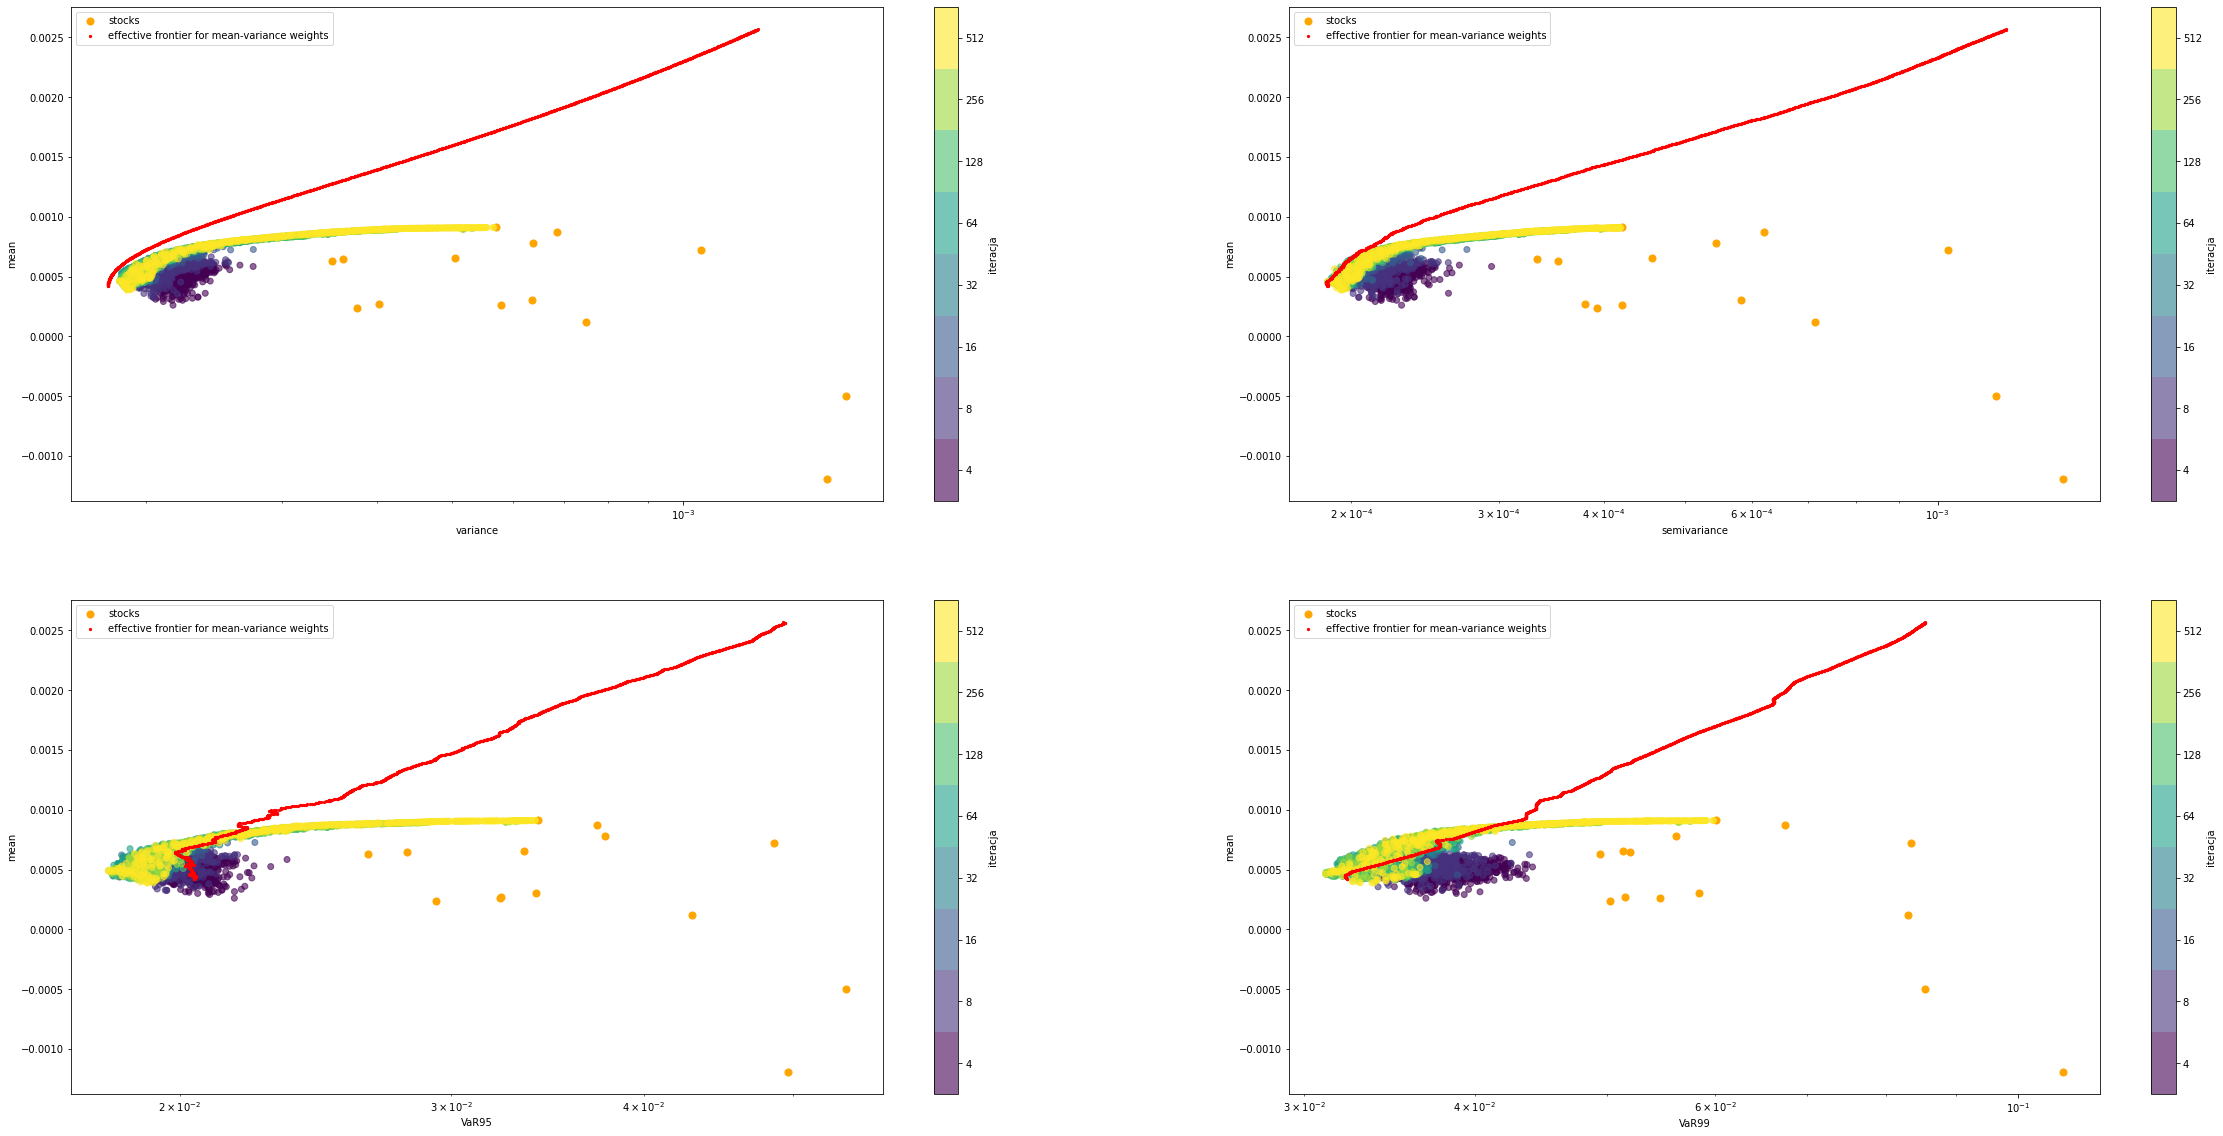

In [20]:
plot(history)

In [21]:
from nsga2.mutations import PolynomialMutation
from nsga2.crossovers import SBX

In [22]:
model = NSGA2(len(R), population_size=500, n_iterations=512, mutation=PolynomialMutation(-1, 1))
history = model.simulate(objective)

100%|██████████| 512/512 [00:54<00:00,  9.41it/s]


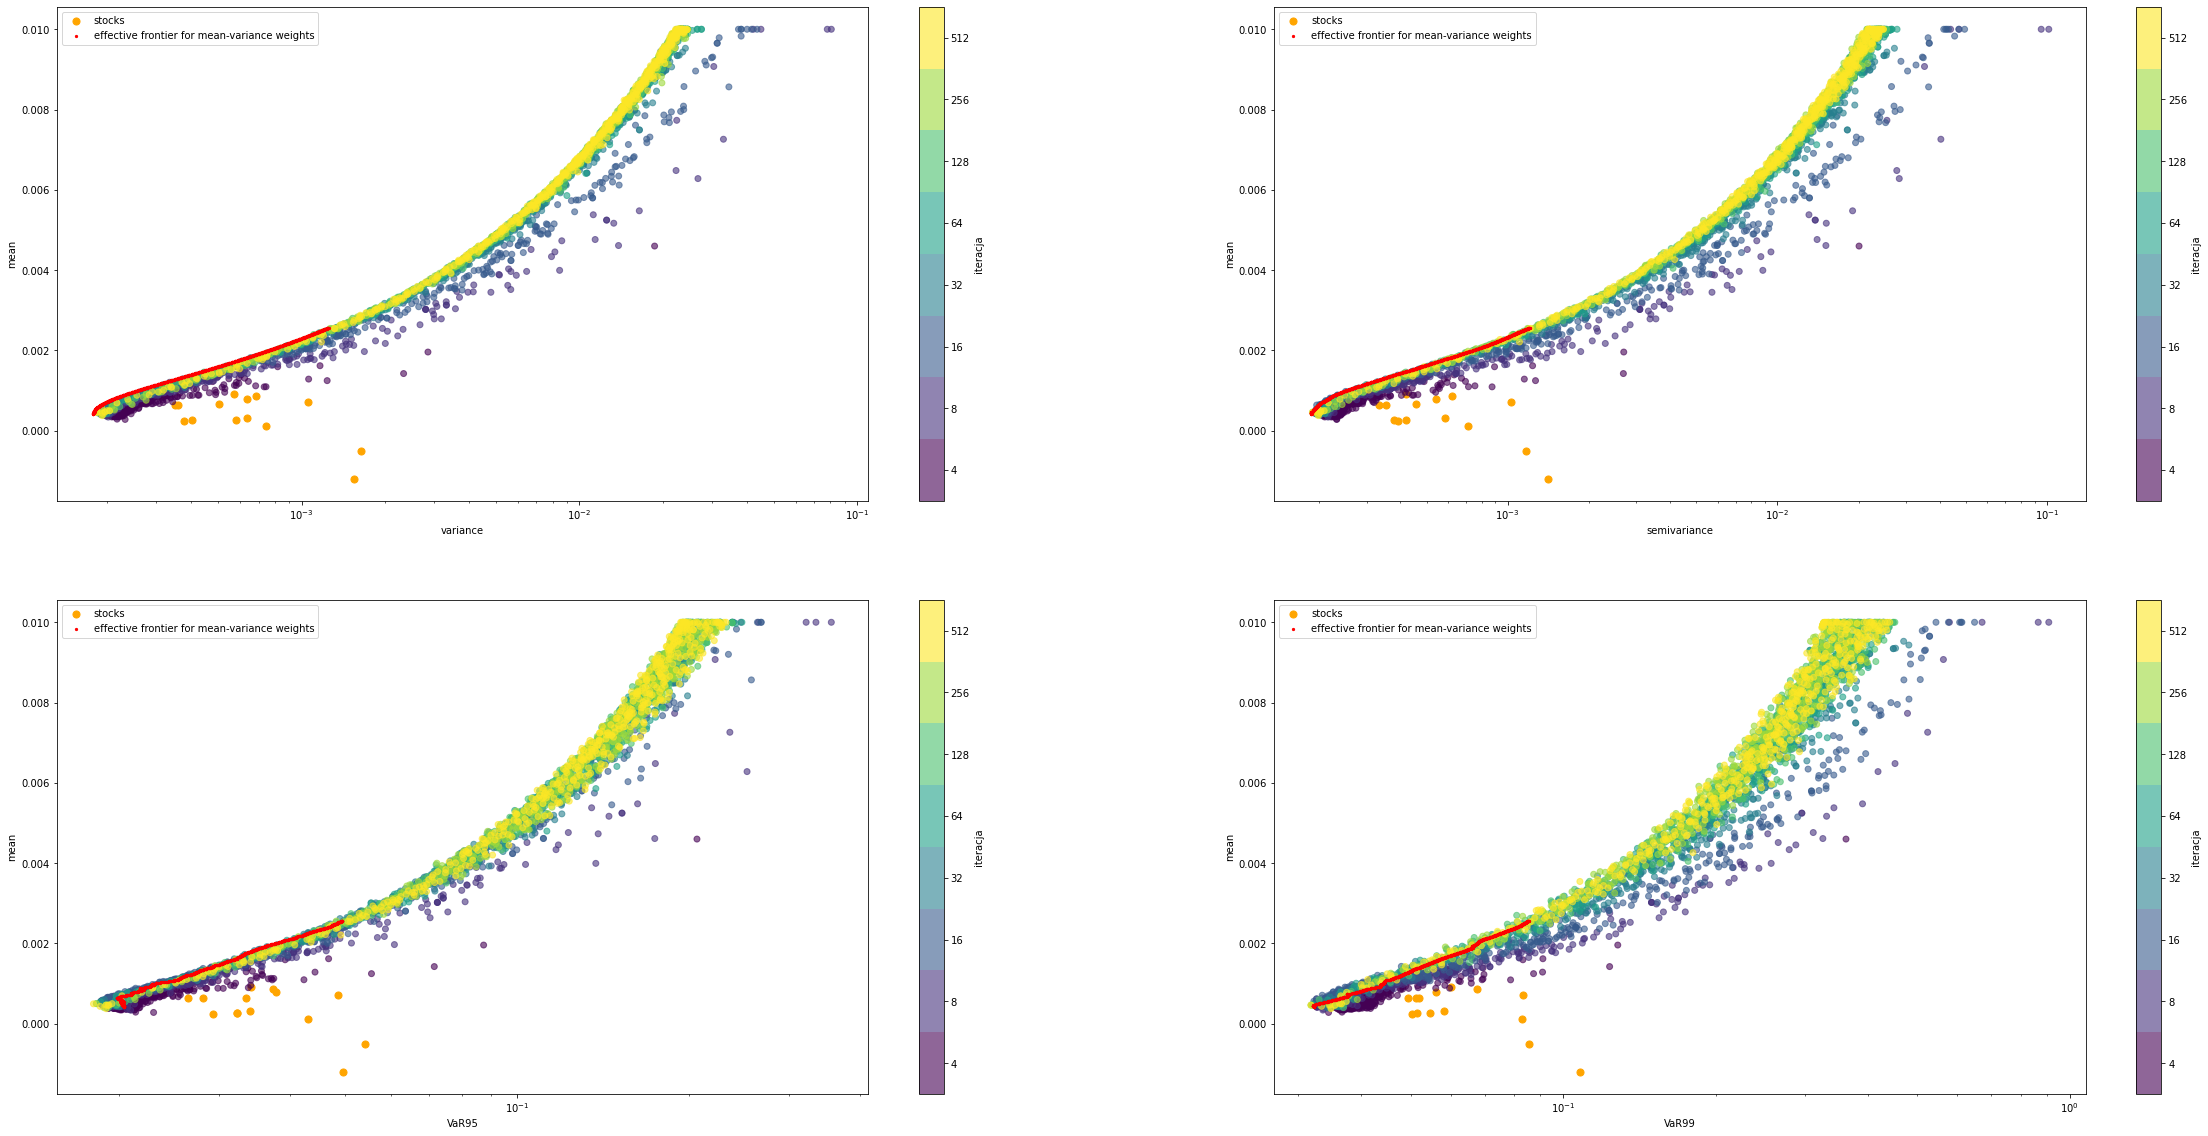

In [23]:
plot(history)

In [24]:
model = NSGA2(len(R), population_size=500, n_iterations=512, crossover=SBX(10))
history = model.simulate(objective)

100%|██████████| 512/512 [00:57<00:00,  8.95it/s]


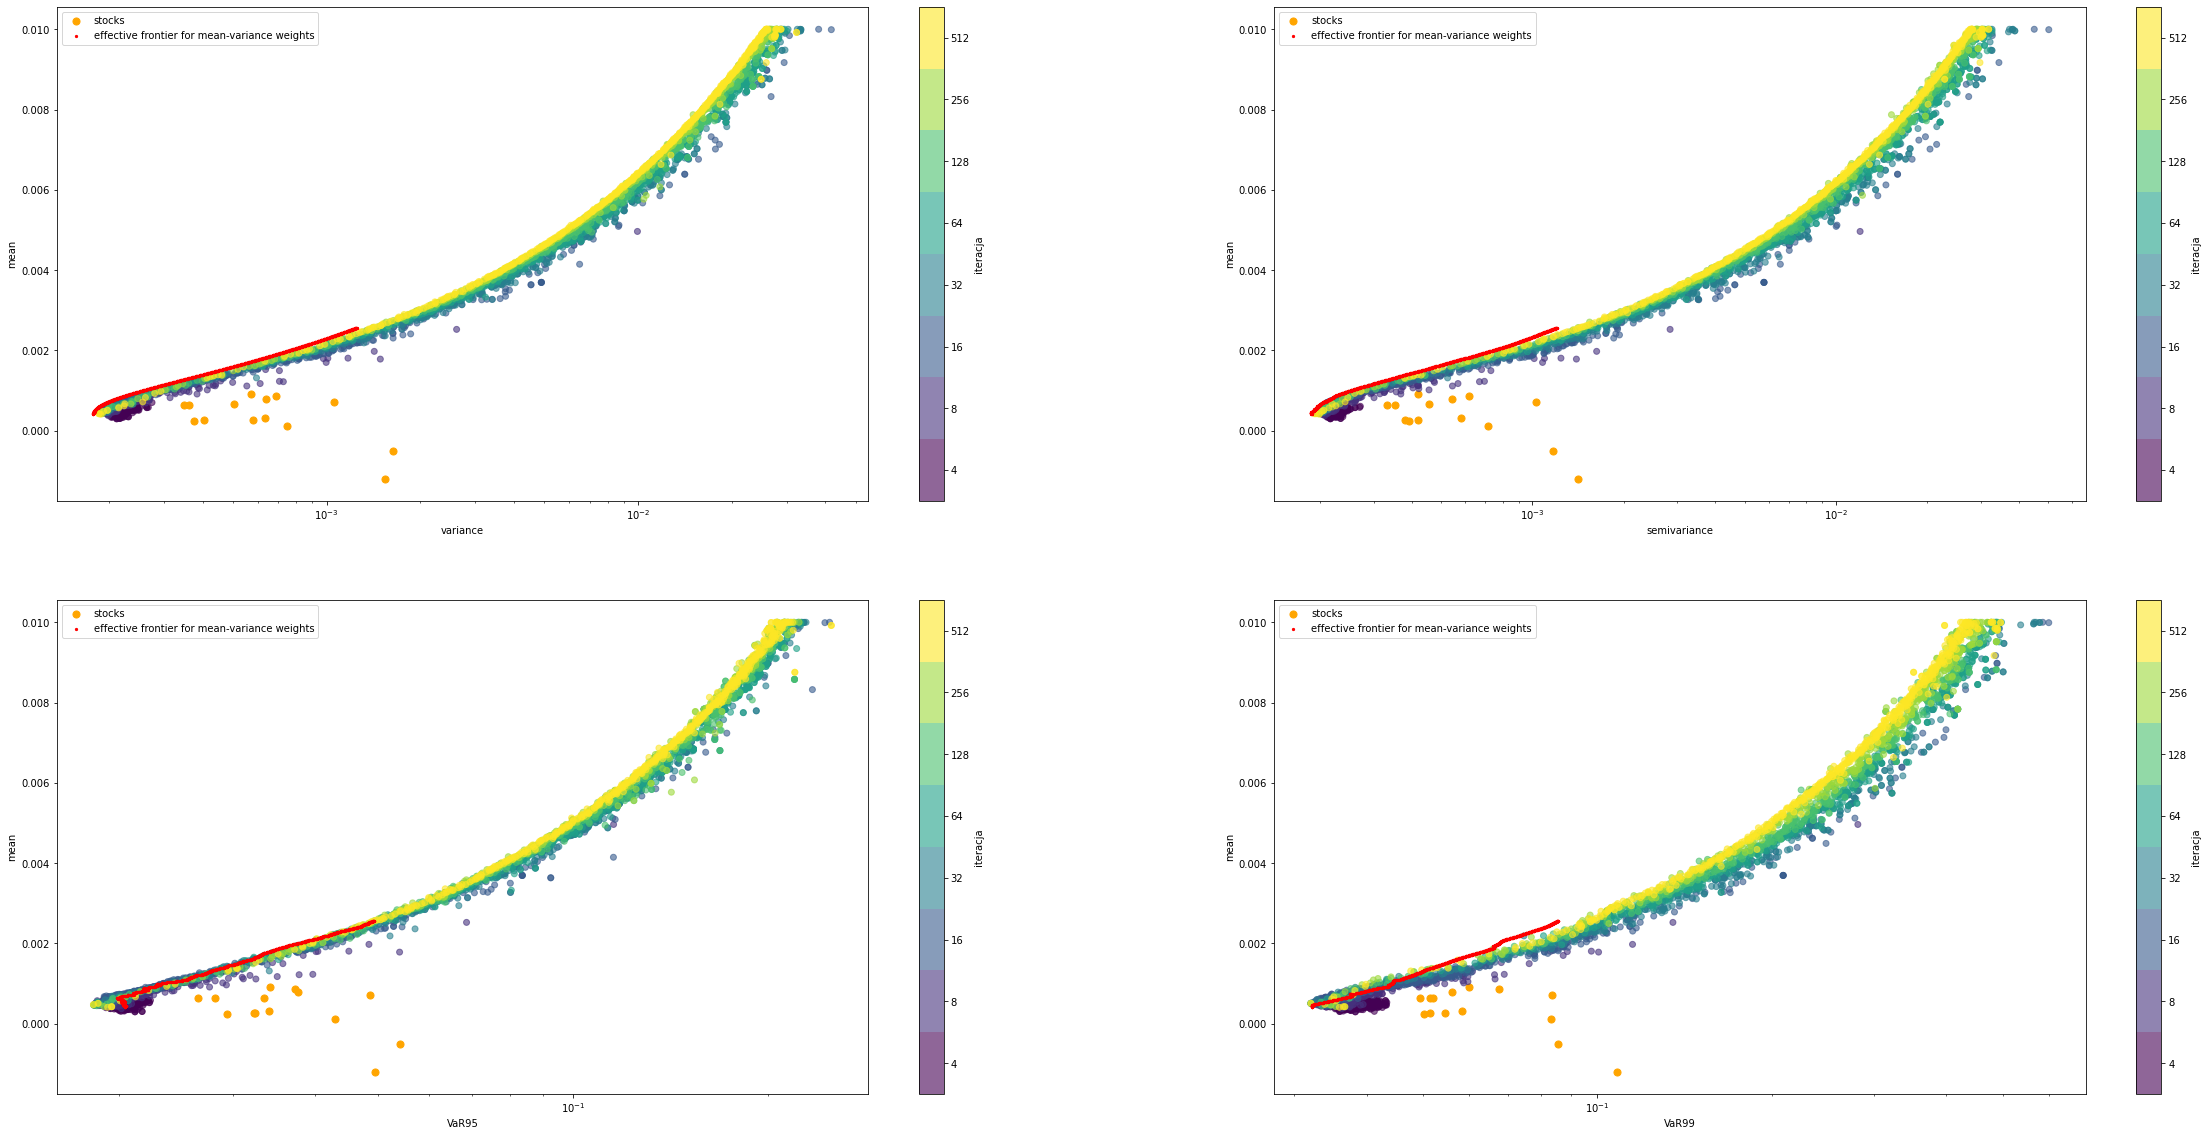

In [25]:
plot(history)

In [26]:
model = NSGA2(len(R), population_size=500, n_iterations=512, crossover=SBX(10), mutation=PolynomialMutation(-1, 1))
history = model.simulate(objective)

100%|██████████| 512/512 [00:59<00:00,  8.63it/s]


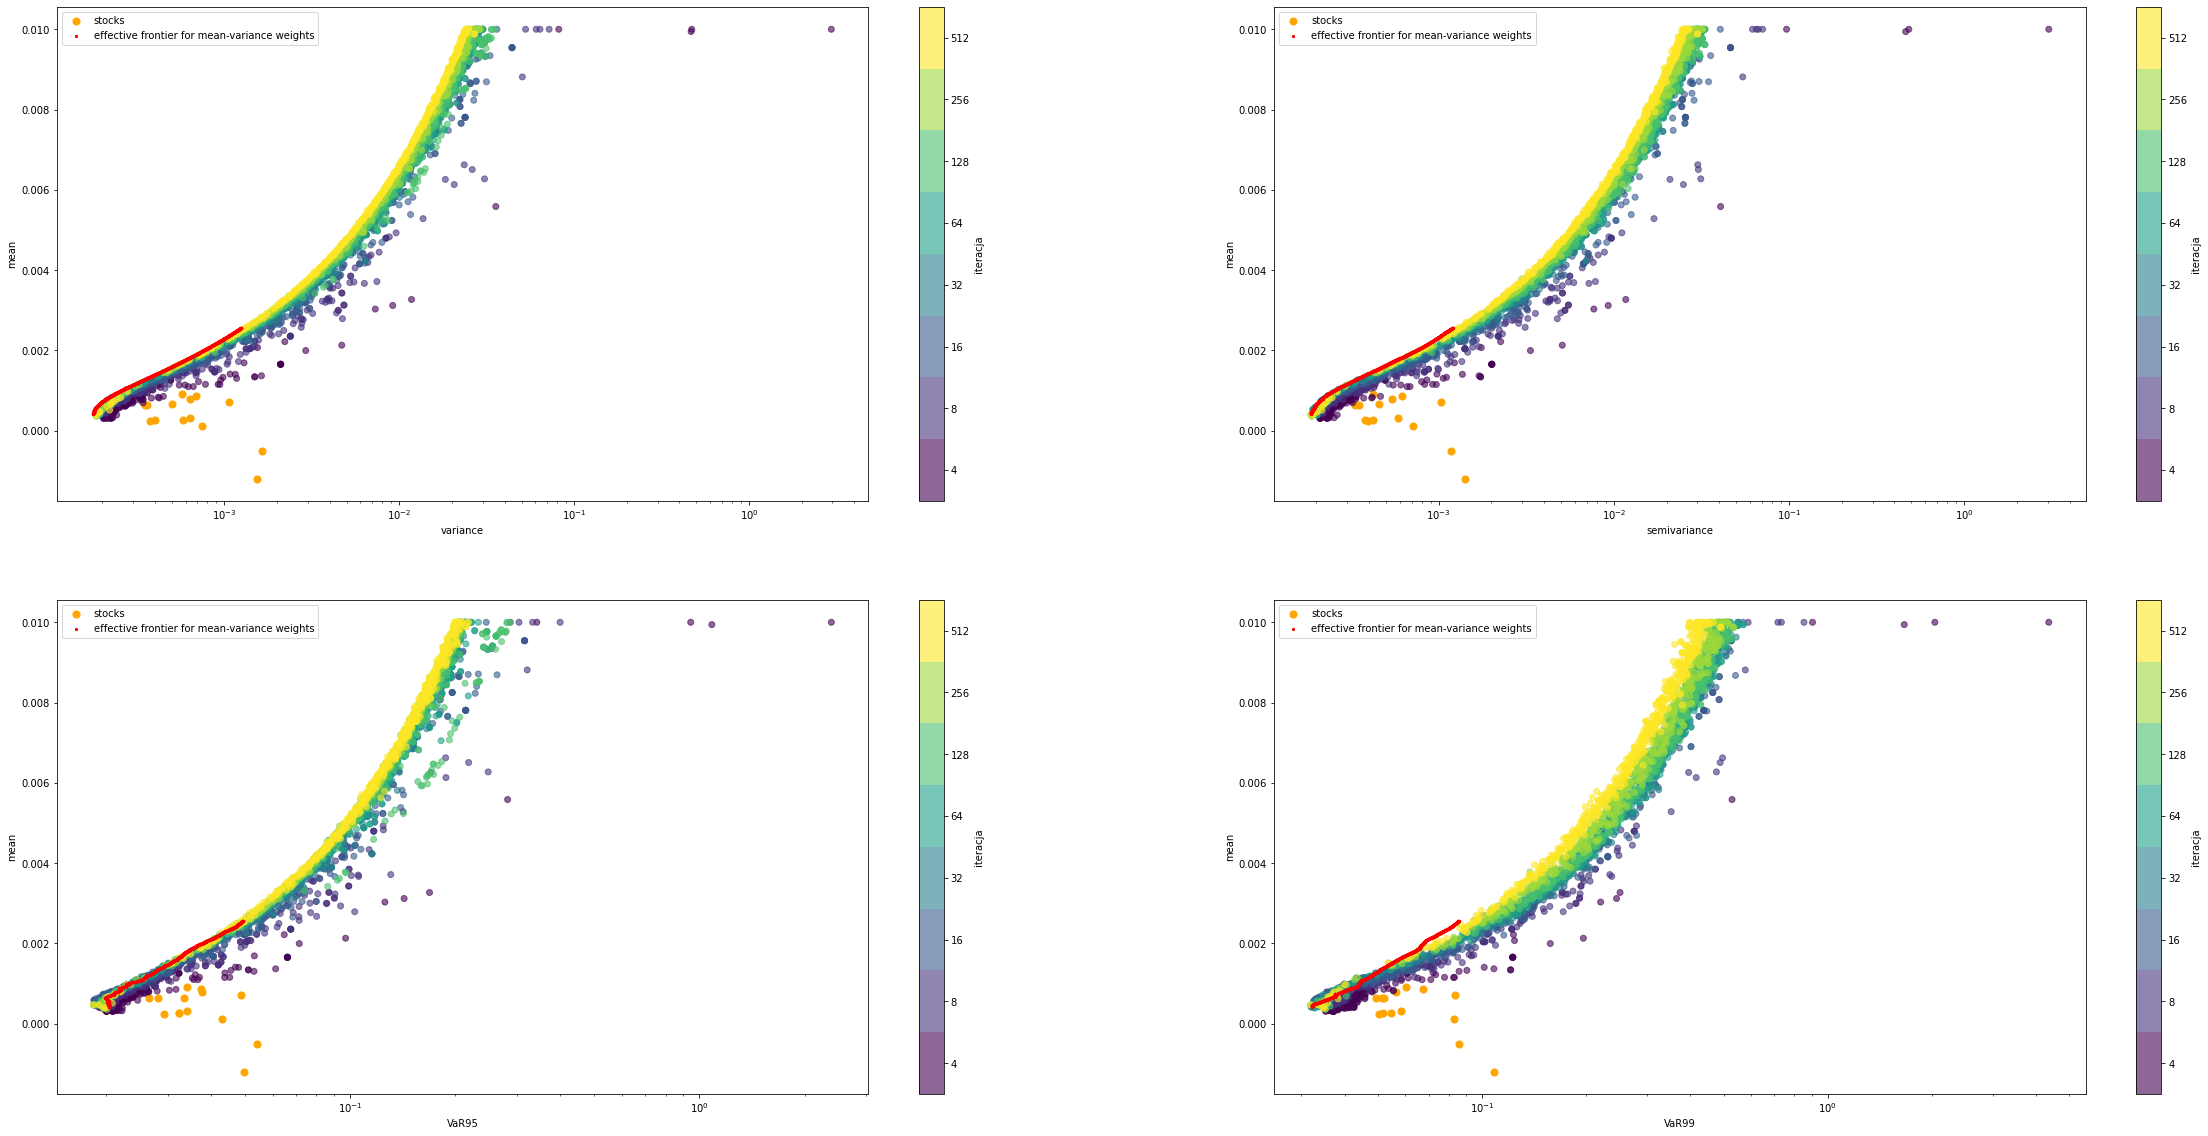

In [27]:
plot(history)